<a href="https://colab.research.google.com/github/RomuloPaiva01/ICA/blob/master/ica_final_2_teste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem:

x = As, where s is the vector with the independent sources, x is the vector with the mixtures that are captured and A is the transformation matrix (done)


z = Vx = VAs, where z is the whitened version of x

Let E = ( 1, 2, ..., n ) be the matrix whose columns are the unit-norm eigenvectors of Cx = E\{xx^t} the covariance matrix 

Let D = diag(d1, d2, ..., dn) be the diagonal matrix of the eigenvalues of C

V = (D^(-1/2))*(E^T)

Alg:

1. Center the data to make its mean zero.

2. Whiten the data to give z.

3. Choose m , the number of independent components to estimate.

4. Choose initial values for the wi , i = 1 , ... , m , each of unit norm. Orthogonalize the matrix W
as in step 6 below.


5.

6.


7. If not converged, go back to step 5.
Table 8.4 The FastICA algorithm for estimating several ICs, with symmetric orthogonal-
ization. The expectations are estimated in practice as sample averages.

![alt text](https://drive.google.com/uc?export=view&id=1kcpsMZYyQhChnltGPM5ujUr_NV3f_unG)


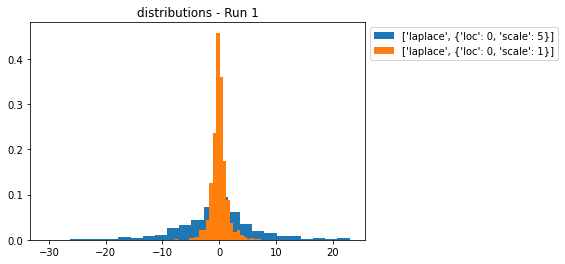

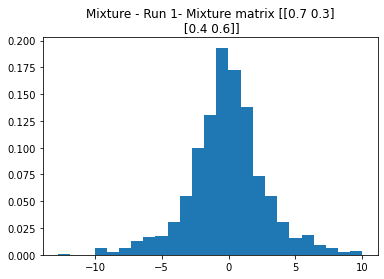

In [1]:
#creating the mixtures
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

#creating the run object
class Run():
    
    def __init__(self, distributions, coefficients, sample_size, name):
        
        self.distributions = distributions
        self.coefficients = coefficients
        self.sample_size = sample_size
        self.name = name
        

#selecting the different distributions with their weights and sample size   
'''
run1 = Run(distributions = [
    {"type": np.random.uniform, "kwargs": {"low": 0, "high":4}},
    {"type": np.random.uniform, "kwargs": {"low": -2, "high":6}},],
    coefficients = np.array([[0.7, 0.3], [0.4, 0.6]]),
    sample_size = 1000,
    name = 'Run 1')
'''

'''
run1 = Run(distributions = [
    {"type": np.random.normal, "kwargs": {"loc": 0, "scale": 3}},
    {"type": np.random.normal, "kwargs": {"loc": 0, "scale": 1}}],
    coefficients = np.array([[0.7, 0.3], [0.4, 0.6]]),
    sample_size = 50000,
    name = 'Run 1')
'''


run1 = Run(distributions = [
    {"type": np.random.laplace, "kwargs": {"loc": 0, "scale": 5}},
    {"type": np.random.laplace, "kwargs": {"loc": 0, "scale": 1}}],
    coefficients = np.array([[0.7, 0.3], [0.4, 0.6]]),
    sample_size = 1000,
    name = 'Run 1')


'''
run1 = Run(distributions = [
    {"type": np.random.laplace, "kwargs": {"loc": 0, "scale": 5}},
    {"type": np.random.uniform, "kwargs": {"low": -2, "high":6}},],
    coefficients = np.array([[0.7, 0.3], [0.4, 0.6]]),
    sample_size = 5000,
    name = 'Run 1')
'''



lst_run = [run1]



#generating and plotting the mixtures
for run in lst_run:

    #number of distributions of each run
    num_distr = len(run.distributions)
    
    #creating a list where we are going to put our data
    data = np.zeros((run.sample_size, num_distr))
    
    #for each distribution I get the data sample, where (a,b) means a from distribution1, b from dist 2 and so on
    for idx, distr in enumerate(run.distributions):
        
        data[:, idx] = distr["type"](size=(run.sample_size,), **distr["kwargs"])
       
    label_distr = []
    
    for i in range((num_distr)):
        label_distr.append([run.distributions[i]['type'].__name__,run.distributions[i]['kwargs']])
        plt.hist(data[np.arange(run.sample_size), i], bins=25, density=True)
    
    plt.title('distributions - ' + run.name)
    plt.legend(label_distr, bbox_to_anchor=(1,1), loc="upper left")
    plt.show()

    
    #changing the shape of the vector
    data_no_mix = data.T
    data = data.T
    #mixing the data
    data = run.coefficients @ data


    #ploting
    plt.hist(data.T[np.arange(run.sample_size), i], bins=25, density=True)
    plt.title('Mixture - ' + run.name + '- Mixture matrix '+ str(run.coefficients))
    plt.show()



In [2]:
data.shape

(2, 1000)

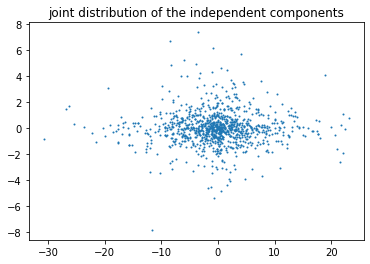

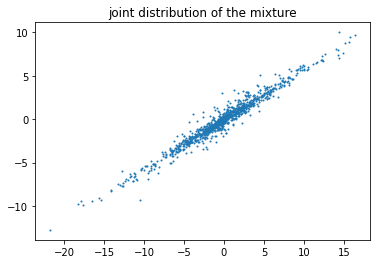

In [3]:
#plotting the joint distributions
def plot_joint(data, title):

  plt.scatter(data[0], data[1], s =1)
  plt.title(title)
  plt.show()


plot_joint(data_no_mix, 'joint distribution of the independent components')

plot_joint(data, 'joint distribution of the mixture')

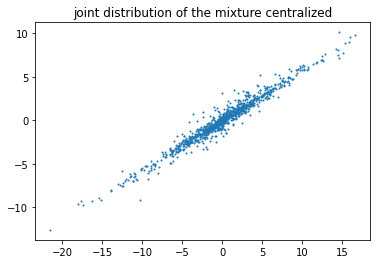

In [4]:
#1- center the data

#We simply find the mean and subtract from each sample
mean = np.mean(data, axis=1)

#data_centered
#data_c = []
data_c = np.zeros((num_distr, run.sample_size))

for i in range(0, run.sample_size):

  data_c[0][i] = data[0][i] - mean[0]

  data_c[1][i] = data[1][i] - mean[1]



plot_joint(data_c, 'joint distribution of the mixture centralized')


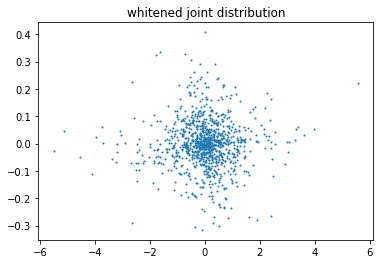

0.5077813260745344


In [5]:
#2- withening the data

'''

Let E = ( 1, 2, ..., n ) be the matrix whose columns are the unit-norm eigenvectors of Cx = E\{xx^t} the covariance matrix 

Let D = diag(d1, d2, ..., dn) be the diagonal matrix of the eigenvalues of C

V = (D^(-1/2))*(E^T)

'''

#first step find the covariance matrix E{xx^t}
C = np.cov(data_c)

#now we can find the unit-norm eigenvectors of C
e_values, e_vectors = np.linalg.eigh(C)


#we need to normalize those vectors
for i in range(len(e_vectors)):

  e_vectors[i] = e_vectors[i]/la.norm(e_vectors[i])


E = e_vectors

#creating an empty D matrix nxn, where n is the number of eigenvalues
D = e_values

#calculating V
z = np.diag(e_values**-1/2) @ e_vectors.T @ data_c

plot_joint(z, 'whitened joint distribution')


neg_entr = 0

#3- choose m, the number of components

m = 2

from scipy.stats import kurtosis


for i in range(m):

  neg_entr +=  (1/12)*(np.mean(z[i]**3))**2  + (1/48)*((kurtosis(z[i]))**2)


print(neg_entr)

In [6]:
z.shape

(2, 1000)

In [7]:
#4- Choose initial values for the wi , i = 1 , ... , m , each of unit norm. Orthogonalize the matrix W with an symmetric orthogonalization.

#for the number of components, I will come up with random unit vectors

#first we need to be able to generate random unit vectors

#dimension
n = run.sample_size


def gen_unit_rand_vec(n):

  #generate random vector
  x = np.random.default_rng().uniform(0,1,n)

  #normalizing it
  x = x/la.norm(x)

  return x
  

#creating the matrix W (or list of vectors)
#W = np.zeros(shape=(m,n), dtype='complex')
W = np.zeros(shape=(m,n))

for i in range(m):

  #W[i][i] = 1

  W[i] = (gen_unit_rand_vec(n))


#print('inicializando w como matriz identidade ou nao, ', W)

#print('checando a ortogonalidade, produto cruzado = ', W[0] @ W[1])

# W = ((W(W^T)^-1/2)W)
def sym_ortagonalization(W):

  #W = np.dot((la.fractional_matrix_power(np.dot(W, W.transpose(), -1/2)), W))

  #print('wwt', W@(W.T) )

  #print('fractional', la.fractional_matrix_power((W@(W.T)),-1/2))

  W = (la.fractional_matrix_power((W@(W.T)),-1/2))@W

  return W


W_aux = sym_ortagonalization(W)

W = W_aux

#print('W ortogonalizado na primeira', W)
#print('checando a ortogonalidade, produto cruzado = ', W[0] @ W[1])
lst_neg_entr = []
lst_w = []

#print('########')
#print('entrando no passo 5')
#print('########')

for j in range(2):
  # Step 5

  print('iteration ', j)

  '''
  wi <- E{zg(wi^T z)} - E{g'(wi^T z)}*w

  where,

  g = y³

  '''



  #print('W antes', W)
  #changing the g
  for i in range(m):

    #W_aux1 = W

    W[i] = (np.dot(z.T, ((np.dot(W[i].T, z.T))**3))) - ((np.dot((3*(np.dot(W[i].T, z.T))**2), W)))

    
  '''
  now we have to define an approximation to the mutual information

  I(y1, y2, ..., yn) = -Sum(E{Gi(yi)}) -log|det B| - H(x)

  s = Bx

  H is the differential entropy



  another approximation and the one that we are going to use is

  I(Y) = const - Sum(J(yi))

  J(y) aprox = 1/12 * E{y³}² + 1/48 * kurt(y)^2

  '''

  #print('W depois de 1', W)

  W_aux = sym_ortagonalization(W)

  W = W_aux

  #print('W depois de 2', W)

  #print('checando a ortogonalidade, produto cruzado = ', W[0] @ W[1])


  neg_entr = 0

  for i in range(m):

    neg_entr +=  (1/12)*(np.mean(W[i]**3))**2  + (1/48)*(kurtosis(W[i]))**2


  lst_neg_entr.append(neg_entr)
  lst_w.append(W)


  def plot_joint2(W):

    lst_x = []

    lst_y = []

    for i in range(len(W[0])):

      lst_x.append(W[0][i])

      lst_y.append(W[1][i])

    plt.scatter(lst_x, lst_y, s =0.5)
    plt.title('joint distribution')
    plt.show()


  #plot_joint2(W)

iteration  0
iteration  1


In [8]:
z

array([[-3.18919162e+00, -1.64448353e+00,  8.30478159e-02, ...,
         2.61513056e-01, -1.61337900e+00,  5.23323901e-01],
       [-2.86807913e-03, -1.99012817e-03,  1.62378428e-01, ...,
        -1.08843336e-01, -6.99956155e-02,  8.12799095e-03]])

In [9]:
W.shape

(2, 1000)

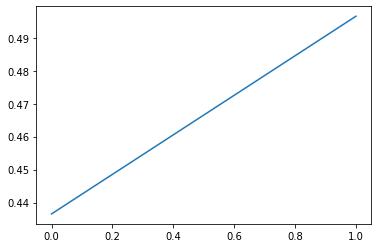

In [10]:
plt.plot(lst_neg_entr)

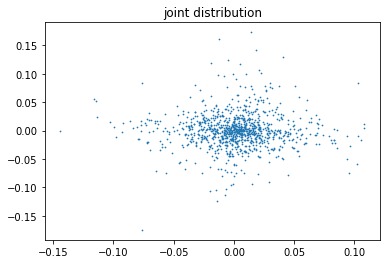

In [11]:
#I will get the best W

index = lst_neg_entr.index(max(lst_neg_entr))



s1 = lst_w[index][0]

s2 = lst_w[index][1]

plot_joint2(lst_w[index])

(array([  1.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,   2.,   1.,   2.,
          2.,   3.,   6.,  10.,   6.,   7.,   9.,   3.,   8.,  18.,  25.,
         26.,  40.,  40.,  55.,  50.,  84., 102.,  98.,  79.,  70.,  60.,
         29.,  30.,  28.,  24.,  12.,  15.,  10.,   8.,   5.,   9.,   1.,
          3.,   6.,   0.,   4.,   3.,   3.]),
 array([-0.1442794 , -0.13922774, -0.13417608, -0.12912442, -0.12407276,
        -0.1190211 , -0.11396944, -0.10891778, -0.10386612, -0.09881446,
        -0.0937628 , -0.08871115, -0.08365949, -0.07860783, -0.07355617,
        -0.06850451, -0.06345285, -0.05840119, -0.05334953, -0.04829787,
        -0.04324621, -0.03819456, -0.0331429 , -0.02809124, -0.02303958,
        -0.01798792, -0.01293626, -0.0078846 , -0.00283294,  0.00221872,
         0.00727038,  0.01232204,  0.01737369,  0.02242535,  0.02747701,
         0.03252867,  0.03758033,  0.04263199,  0.04768365,  0.05273531,
         0.05778697,  0.06283863,  0.06789029,  0.07294194,  0.0779936 ,
 

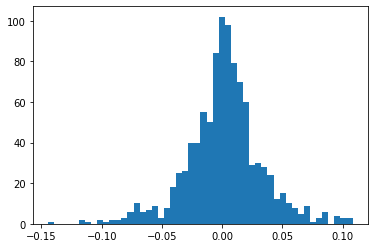

In [12]:
plt.hist(s1.T, bins = 50)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   2.,
          3.,   1.,   3.,   9.,   6.,   7.,   8.,  17.,  28.,  35.,  49.,
         83., 100., 143., 154.,  91.,  70.,  56.,  31.,  27.,  15.,  15.,
          9.,   3.,   5.,   9.,   3.,   2.,   4.,   1.,   1.,   1.,   2.,
          0.,   1.,   0.,   0.,   1.,   1.]),
 array([-0.17511803, -0.16815227, -0.16118651, -0.15422075, -0.14725499,
        -0.14028923, -0.13332347, -0.12635771, -0.11939195, -0.11242619,
        -0.10546043, -0.09849467, -0.09152891, -0.08456315, -0.07759739,
        -0.07063163, -0.06366587, -0.05670011, -0.04973435, -0.04276859,
        -0.03580283, -0.02883707, -0.0218713 , -0.01490554, -0.00793978,
        -0.00097402,  0.00599174,  0.0129575 ,  0.01992326,  0.02688902,
         0.03385478,  0.04082054,  0.0477863 ,  0.05475206,  0.06171782,
         0.06868358,  0.07564934,  0.0826151 ,  0.08958086,  0.09654662,
         0.10351238,  0.11047814,  0.1174439 ,  0.12440966,  0.13137542,
 

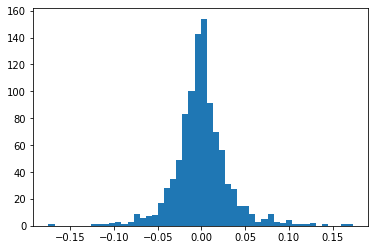

In [13]:
plt.hist(s2, bins = 50)